In [1]:
import os, time, gc
import numpy as np
import datatable as dt
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit
import treelite, treelite_runtime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
path = '/kaggle/working/input/'
# path = '/kaggle/input/jane-street-market-prediction'
train = dt.fread(os.path.join(path, 'train.csv')).to_pandas()

train = train[train['weight'] != 0].reset_index(drop = True)
f_mean = train.mean()
train = train.fillna(f_mean)

features = [c for c in train.columns if 'feature' in c]

train['action'] = (train['resp'].values > 0).astype(int)

X_train = train.loc[train['date'] > 85, features].values
y_train = train.loc[train['date'] > 85, 'action'].values
del train

CPU times: user 10min 11s, sys: 37.2 s, total: 10min 48s
Wall time: 30.5 s


# Principal Components Analysis(PCA)

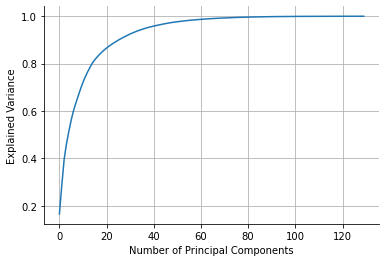

In [3]:
PCA_appied = True
if PCA_appied:
    # 归一化
    scaler = StandardScaler()
    scaler.fit(X_train)
    norm_X_train = scaler.transform(X_train)

    # 主成分分析
    pca = PCA()
    comp = pca.fit(norm_X_train)

    # 在保留不同的维度个数时的方差和
    plt.plot(np.cumsum(comp.explained_variance_ratio_))
    plt.grid()
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Explained Variance')
    sns.despine()
    
    pca = PCA(n_components=50).fit(norm_X_train)
    X_train = pca.transform(norm_X_train)

In [21]:
%%time
dtrain = xgb.DMatrix(X_train, y_train)
params = {
    'n_estimators': 500,
    'max_depth': 8,
    'learning_rate': 0.014,
    'subsample': 0.46,
    'colsample_bytree': 0.99,
    'objective': 'binary:logistic',
    'random_state': 2020,
    'tree_method': 'gpu_hist',
    'eval_metric': 'logloss'
}
clf = xgb.train(params, dtrain, 200)

[16:43:41] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 39.7 s, sys: 9.24 s, total: 49 s
Wall time: 19.8 s


In [24]:
model = treelite.Model.from_xgboost(clf)
toolchain = 'gcc'
model.export_lib(toolchain=toolchain, libpath='./mymodel.so', params={'parallel_comp': 32}, verbose=True)
predictor = treelite_runtime.Predictor('./mymodel.so', verbose=True)

[16:47:44] ../src/compiler/ast_native.cc:45: Using ASTNativeCompiler
[16:47:44] ../src/compiler/ast/split.cc:31: Parallel compilation enabled; member trees will be divided into 32 translation units.
[16:47:44] ../src/c_api/c_api.cc:120: Code generation finished. Writing code to files...
[16:47:44] ../src/c_api/c_api.cc:125: Writing file recipe.json...
[16:47:44] ../src/c_api/c_api.cc:125: Writing file tu27.c...
[16:47:44] ../src/c_api/c_api.cc:125: Writing file tu22.c...
[16:47:44] ../src/c_api/c_api.cc:125: Writing file tu24.c...
[16:47:44] ../src/c_api/c_api.cc:125: Writing file tu21.c...
[16:47:44] ../src/c_api/c_api.cc:125: Writing file tu8.c...
[16:47:44] ../src/c_api/c_api.cc:125: Writing file tu5.c...
[16:47:44] ../src/c_api/c_api.cc:125: Writing file tu6.c...
[16:47:44] ../src/c_api/c_api.cc:125: Writing file tu3.c...
[16:47:44] ../src/c_api/c_api.cc:125: Writing file tu7.c...
[16:47:44] ../src/c_api/c_api.cc:125: Writing file tu26.c...
[16:47:44] ../src/c_api/c_api.cc:125: Wri

In [53]:
@njit
def fast_fillna(array, values):
    if np.isnan(array.sum()):
        array = np.where(np.isnan(array), values, array)
    return array

In [54]:
import janestreet
env = janestreet.make_env()
iter_test = env.iter_test()

In [55]:
%%time
opt_th = 0.505
tmp = np.zeros(len(features))
for (test_df, prediction_df) in tqdm(iter_test):
    if test_df['weight'].values[0] > 0:
        x_tt = test_df.loc[:, features].values
        x_tt[0, :] = fast_fillna(x_tt[0, :], tmp)
        tmp = x_tt[0, :]
        if PCA_appied:
#             y_preds = clf.predict(pca.transform(x_tt))
            y_preds = predictor.predict(treelite_runtime.DMatrix(pca.transform(x_tt)))
        else:
#             y_preds = clf.predict(x_tt)
            y_preds = predictor.predict(treelite_runtime.DMatrix(x_tt))
        prediction_df["action"].values[0] = int(y_preds >= 0.5)
    else:
        prediction_df["action"].values[0] = 0
    env.predict(prediction_df)

0it [00:00, ?it/s]

CPU times: user 1min 54s, sys: 1.38 s, total: 1min 56s
Wall time: 1min 55s
